This notebook presents the model developed in this paper, as explained in the "Two-Dimensional Tuning Curves" section of the Methods. The following briefly shows how to initialize the model, both with user-specified values and those presented in our paper, how to use the model to generate predictions, and how to fit the model to some simulated voxels.

Also note that if you're only interested in exploring how the model's predictions change with different parameter values, I've put together a little [webapp](https://wfbroderick.com/spatial-frequency-model/) for that purpose (here's the [github repo](https://github.com/billbrod/spatial-frequency-model) in case that first link goes down). The github repo also contains a version of the model that's separate from the rest of the code base (and with fewer requirements), if you want to reuse the model code in a separate project (if you do, please cite us! see [readme](https://github.com/billbrod/spatial-frequency-preferences) for details).

In [1]:
# import necessary packages
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import sfp 
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns

## User-specified parameter values

In the code, the model is referred to as `LogGaussianDonut`. The first thing to take care of when initializing the model is the submodel type, as described in the "Model Selection" section of the paper. This determines the first three arguments to the class: `period_orientation_type` (how orientation affects preferred period), `eccentricity_type` (how preferred period depends on eccentricity), and `amplitude_orientation_type` (how orientation affects relative gain). See the docstring of `LogGaussianDonut` for more details.

For the following, we'll do a relatively simple model, one in which preferred period is an affine function of eccentricity (i.e., $p=ar_v+b$), with no effect of relative or absolute orientation on preferred period or relative gain (i.e., submodel 3). Thus, `period_orientation_type='iso',eccentricity_type='full',amplitude_orientation_type='iso'`, the default values. We also have to pick values for the parameters, and we'll pick values for `sigma`, `sf_ecc_slope` ($a$ in the paper), and `sf_ecc_intercept` ($b$) that roughly match those presented in the paper. All other parameters will be set to zero.

In [2]:
model = sfp.model.LogGaussianDonut(sigma=2, sf_ecc_slope=.12, sf_ecc_intercept=.35)
model

LogGaussianDonut(sigma: 2.000, sf_ecc_slope: 0.120, sf_ecc_intercept: 0.350, abs_amplitude_cardinals: 0.000, abs_amplitude_obliques: 0.000, abs_mode_cardinals: 0.000, abs_mode_obliques: 0.000, rel_amplitude_cardinals: 0.000, rel_amplitude_obliques: 0.000, rel_mode_cardinals: 0.000, rel_mode_obliques: 0.000)

Once we have the model, we can call `evaluate` to get the model's predictions for an arbtirary voxel and stimulus. Let's say we have a voxel and stimulus with the following properties:

In [3]:
voxel_ecc = 2 # degrees
voxel_angle = np.pi # radians
sf_magnitude = 1 # cycles / degree
sf_orientation = 0 # radians

model.evaluate(sf_magnitude, sf_orientation, voxel_ecc, voxel_angle)

tensor(0.9301, grad_fn=<MulBackward0>)

Of course, by itself, this isn't all that useful to us. We can have the model return its preferred period as a function of eccentricity, if we want a bit more information:

In [4]:
ecc = torch.linspace(0, 12)
sf_ori = torch.tensor([0, np.pi/2])

pref_period = model.preferred_period(ecc, voxel_angle, sf_ori)

Note that we pass torch tensors as the input here. If you're using single numbers, regular python floats or ints are fine, but if you have multiple, you need to use tensors.

We now have the preferred period for eccentricities 0 to 12, for two stimulus orientations (0 and $\pi/2$). Let's plot it:

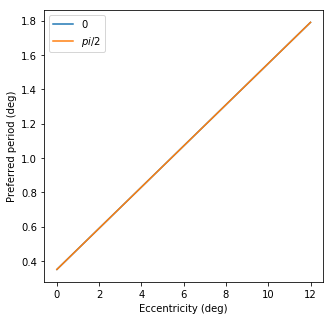

In [5]:
# we have to convert the tensors back to numpy arrays to plot them
fig, ax = plt.subplots(1, 1, figsize=(5, 5),)
plt.plot(ecc.numpy(), pref_period.detach().numpy())
ax.set(xlabel='Eccentricity (deg)', ylabel='Preferred period (deg)', )
plt.legend([0, '$pi/2$'])

We can see that the two lines are on top of each other, because our model has no effect of stimulus orientation on preferred period. If we create a new instance, which does have an effect, we can see that reflected as well:

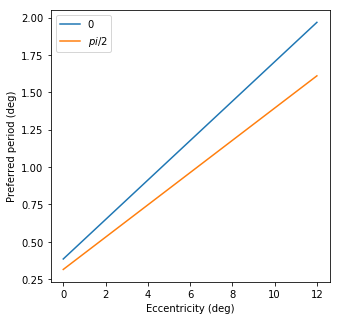

In [6]:
model = sfp.model.LogGaussianDonut('absolute', sigma=2, sf_ecc_slope=.12, sf_ecc_intercept=.35, abs_mode_cardinals=.1)
pref_period = model.preferred_period(ecc, voxel_angle, sf_ori)
fig, ax = plt.subplots(1, 1, figsize=(5, 5),)
plt.plot(ecc.numpy(), pref_period.detach().numpy())
ax.set(xlabel='Eccentricity (deg)', ylabel='Preferred period (deg)', )
plt.legend([0, '$pi/2$'])

The model has similar methods for generating the preferred period contours and relative gain contours that are plotted in the paper.

## Parameters from the paper

If you want to use the model with the specific parameter values found in the paper, you can load them in from the `csv` files found at `data/tuning_2d_model`: 
- `combined_subject_params.csv` contains the parameter values from combining across subjects, as presented in the main body of the paper.
- `individual_subject_params.csv` contains the parameter values from each subject individually, as shown in Figure 9B and the appendix.

Let's load in the `combined_subject_params` now:

In [7]:
df = pd.read_csv('../data/tuning_2d_model/combined_subject_params.csv')
df.head()

,fit_model_type,model_parameter,subject,bootstrap_num,fit_value
0,full_donut_period-full_amps-absolute,abs_amplitude_cardinals,all,0,0.033102
1,full_donut_period-full_amps-absolute,abs_amplitude_cardinals,all,1,0.048524
2,full_donut_period-full_amps-absolute,abs_amplitude_cardinals,all,2,0.043815
3,full_donut_period-full_amps-absolute,abs_amplitude_cardinals,all,3,0.052916
4,full_donut_period-full_amps-absolute,abs_amplitude_cardinals,all,4,0.042614


Both csvs have five columns: `fit_model_type`, `model_parameter`, `subject`, `bootstrap_num` and `fit_value`:
- `fit_model_type` (str): the (long) name of this submodel. Both csvs only contain a single model, which corresponds to model 9 in our paper, the best-fit one.
- `subject` (str): the subject whose parameters these are. In `combined_subject_params`, there's only one subject, `'all'`.
- `bootstrap_num` (int): the bootstrap number. Each combination of `model_parameter` and `subject` has 100 bootstraps. For `combined_subject_params`, these are the bootstraps used to combine across subjects in a precision-weighted average. For `individual_subject_params`, these are the bootstraps across fMRI runs. See paper for more details.
- `fit_value` (float): the actual value of the parameter.
- `model_parameter` (str): the (long) name of the model parameter. The following block shows the mapping between these and the model names found in the paper.

In [8]:
dict((k, v) for k, v in zip(sfp.plotting.ORIG_PARAM_ORDER, sfp.plotting.PLOT_PARAM_ORDER))

{'sigma': '$\\sigma$',
 'sf_ecc_slope': '$a$',
 'sf_ecc_intercept': '$b$',
 'abs_mode_cardinals': '$p_1$',
 'abs_mode_obliques': '$p_2$',
 'rel_mode_cardinals': '$p_3$',
 'rel_mode_obliques': '$p_4$',
 'abs_amplitude_cardinals': '$A_1$',
 'abs_amplitude_obliques': '$A_2$',
 'rel_amplitude_cardinals': '$A_3$',
 'rel_amplitude_obliques': '$A_4$'}

For the following, let's use the median combined parameters:

In [9]:
# this takes the median across bootstraps
median_df = df.groupby(['fit_model_type', 'subject', 'model_parameter']).median().reset_index()

# we have a convenience function for creating a model from these dataframes. 
# it will throw an exception if you give it a dataframe with more than one model in it
model = sfp.model.LogGaussianDonut.init_from_df(median_df)

We can now use this model as above:

In [10]:
model.evaluate(sf_magnitude, sf_orientation, voxel_ecc, voxel_angle)

tensor(0.9873, grad_fn=<MulBackward0>)

## Many voxels

The above is fine, but you probably want to generate predictions for many voxels at once. Let's simulate a bunch of voxels and do that.

In order to simulate voxels, we need to give it the true response model. For right now, let's use the simple model we started with.

In [11]:
simple_model = sfp.model.LogGaussianDonut(sigma=2, sf_ecc_slope=.12, sf_ecc_intercept=.35)
simulated_voxels = sfp.simulate_data.simulate_data(simple_model, num_voxels=100, num_bootstraps=1)

This creates a dataframe with a lot of info in it. Let's look at where our voxels are located:

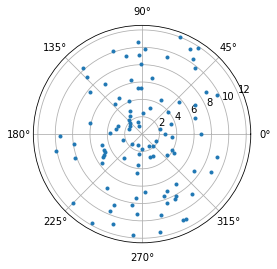

In [12]:
plt.polar(simulated_voxels.drop_duplicates('voxel').angle, simulated_voxels.drop_duplicates('voxel').eccen, '.')

Seems like a reasonable distribution of locations.

For our purposes here, let's just grab the voxel pRF locations and stimulus information (which roughly match those found in our stimuli).

In [13]:
data = simulated_voxels[['local_sf_magnitude', 'local_sf_xy_direction', 'eccen', 'angle']].values
# need to convert this to a torch tensor
data = torch.from_numpy(data)

Note the shape of this data: number of observations by 4, where the four columns correspond to the stimulus's local spatial frequency, local orientation (in absolute coordinates), voxel eccentricity, and voxel retinotopic angle.

In [14]:
data.shape

torch.Size([4800, 4])

When we call the model on this tensor, we get a prediction for each row.

In [15]:
predictions = model(data)
predictions.shape

torch.Size([4800])

The above use of `sfp.simulate_data` is just an example; as long as you create a 2d tensor with observations on the rows and the four specified columns (in that order), you can call `model` on it to generate a bunch of predictions.

## Example fitting

Let's try and fit our model to the above. This is a simple little loop, not exactly the same as what we did in our paper, but should get you started if you want to fit the model yourself.

First, let's simulate the data again, this time with some Gaussian noise in it.

In [16]:
simple_model = sfp.model.LogGaussianDonut(sigma=2, sf_ecc_slope=.12, sf_ecc_intercept=.35)
# we'll simulate multiple bootstraps (which are independent samples) and then take the median across them.
simulated_voxels = sfp.simulate_data.simulate_data(simple_model, num_voxels=1000, noise_level=.05, num_bootstraps=12)
simulated_voxels = simulated_voxels.groupby(['voxel', 'stimulus_class']).median().reset_index()

Let's look at the response of some of our noisy simulated voxels. Our true model has no effect of orientation , so any variation we see in the response as a function of spatial frequency is due to the noise. We can see that these are noisy, but look recognizably like log-Gaussians

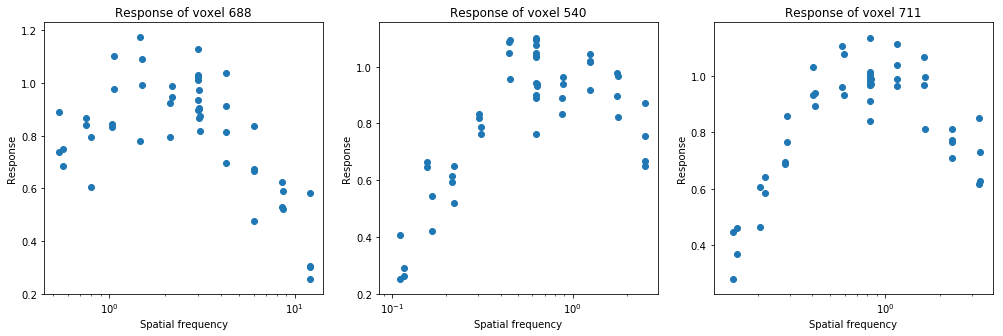

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5))
for ax in axes:
    vox_idx = np.random.randint(simulated_voxels.voxel.nunique())
    tmp = simulated_voxels.query(f'voxel=={vox_idx}')
    ax.scatter(tmp.local_sf_magnitude, tmp.amplitude_estimate_median)
    ax.set(title=f'Response of voxel {vox_idx}', xlabel='Spatial frequency', ylabel='Response', xscale='log')

In [18]:
features = simulated_voxels[['local_sf_magnitude', 'local_sf_xy_direction', 'eccen', 'angle']].values
features = torch.from_numpy(features).to(torch.float32)
# target contains the values we're trying to predict and the precision (precision here comes from the noise level of each voxel)
target = torch.from_numpy(simulated_voxels[['amplitude_estimate_median', 'precision']].values).to(torch.float32)
# reshape these so they're 3d: voxels, stimulus class, features. 
features = features.reshape(simulated_voxels.voxel.nunique(), simulated_voxels.stimulus_class.nunique(), 4)
target = target.reshape(simulated_voxels.voxel.nunique(), simulated_voxels.stimulus_class.nunique(), 2)

Let's initialize our model, our optimizer, and some lists to keep track of information:

In [19]:
# we'll initialize with random values for our parameters
rand_params = np.random.rand(11)
model = sfp.model.LogGaussianDonut('full', 'full', 'full', *rand_params)
opt = torch.optim.Adam([p for p in model.parameters() if p.requires_grad], lr=.001, amsgrad=True)
loss_history = []
model_history = []

Next let's run this for 2000 iterations, just to get a sense for how well it does:

In [20]:
pbar = tqdm(range(2000))
for i in pbar:
    # this is what a standard pytorch optimization loop looks like, see their docs for more details
    # https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html#full-implementation
    preds = model(features)
    loss = sfp.model.weighted_normed_loss(preds, target)
    # keep track of model parameter history
    model_history.append([(k, v.item()) for k, v in model.named_parameters()])
    # keep track of loss
    pbar.set_postfix(loss=loss.item())
    loss_history.append(loss.item())
    opt.zero_grad()
    loss.backward()
    opt.step()

Let's plot the loss and see how we're doing. We can see that our loss is continuing to decrease -- we're slowing down, but we haven't converged yet.

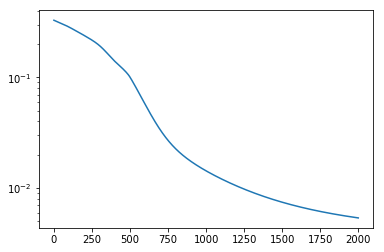

In [21]:
plt.semilogy(loss_history)

We can similarly look at the parameter values:

In [22]:
model_history = pd.DataFrame([dict(m) for m in model_history]).reset_index().rename(columns={'index': 'iteration'})
model_history = model_history.melt('iteration', value_name='fit_value')

In the following plot, the solid lines give the trained parameter value at each iteration, while the dashed one gives the true value. We can see, by 2000 iterations, all of our unnecessary variables have converged to 0, and the three others (sigma, sf_ecc_intercept, sf_ecc_slope) are all approaching their true values as well:

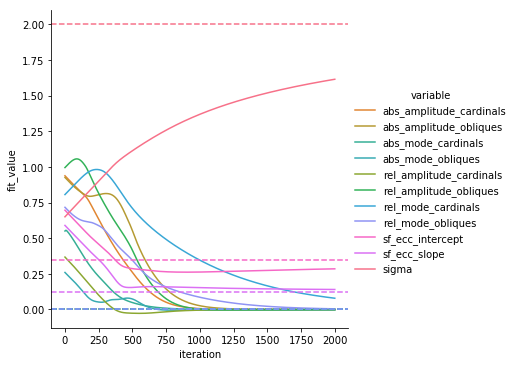

In [23]:
pal = {k: v for (k, _), v in zip(simple_model.named_parameters(), sns.color_palette('husl', 11))}
g = sns.relplot(x='iteration', y='fit_value', hue='variable', data=model_history, kind='line', palette=pal)
for k, v in simple_model.named_parameters():
    g.ax.axhline(v.item(), 0, model_history.iteration.max(), linestyle='--', color=pal[k])

We could keep going. If you'd like, rerun the block with the training loop (**not** the one where we initialized `model`) to continue training!